# Visualise Examples

[#140](https://github.com/chengsoonong/crowdastro/issues/140)

In [20]:
import h5py, sklearn.linear_model, sklearn.metrics, matplotlib.pyplot as plt, seaborn, sklearn.neighbors, numpy
from astropy.coordinates import SkyCoord

%matplotlib inline

NORRIS_DAT_PATH = '../data/norris_2006_atlas_classifications_ra_dec_only.dat'

# Load Norris labels.
with h5py.File('../data/training.h5', 'r') as training_f:
    ir_positions = training_f['positions'].value
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

with h5py.File('../data/training.h5') as f:
    features = f['features'].value
    labels = f['labels'].value
    ir_test = f['is_ir_test'].value.astype(bool)
    ir_train = f['is_ir_train'].value.astype(bool)

In [7]:
lr = sklearn.linear_model.LogisticRegression(C=100.0, class_weight='balanced')

In [8]:
lr.fit(features[ir_train], labels[ir_train])

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
cm = sklearn.metrics.confusion_matrix(labels[ir_test], lr.predict(features[ir_test]))
tp = cm[1, 1]
n, p = cm.sum(axis=1)
tn = cm[0, 0]
ba = (tp / p + tn / n) / 2
ba

0.8976176771377945

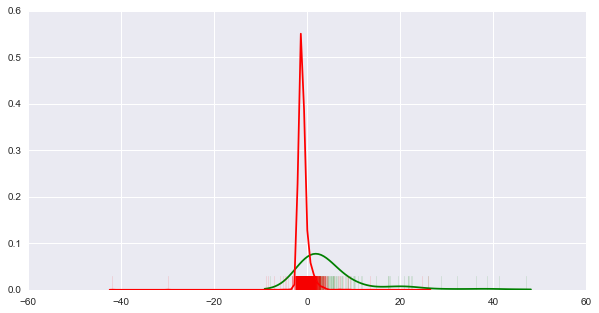

In [24]:
score = lr.decision_function(features[ir_test])
predicted_labels = lr.predict(features[ir_test])
pos_score = score[norris_labels[ir_test] == 1]
neg_score = score[norris_labels[ir_test] == 0]
assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
plt.figure(figsize=(10, 5))
seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
plt.show()

In [77]:
# Positive examples incorrectly classified as negative.
false_negatives = numpy.logical_and(norris_labels[ir_test] == 1, predicted_labels == 0).nonzero()[0]
false_negatives = false_negatives[score[false_negatives].argsort()]
true_positives = numpy.logical_and(norris_labels[ir_test] == 1, predicted_labels == 1).nonzero()[0]
true_positives = true_positives[score[true_positives].argsort()]

most_negative = numpy.arange(features.shape[0])[ir_test][false_negatives[:5]]
least_negative = numpy.arange(features.shape[0])[ir_test][false_negatives[-5:]]
most_positive = numpy.arange(features.shape[0])[ir_test][true_positives[-5:]]

print(lr.predict(features[most_negative]), norris_labels[most_negative], lr.decision_function(features[most_negative]))
print(lr.predict(features[least_negative]), norris_labels[least_negative], lr.decision_function(features[least_negative]))
print(lr.predict(features[most_positive]), norris_labels[most_positive], lr.decision_function(features[most_positive]))

[False False False False False] [ 1.  1.  1.  1.  1.] [-8.05719026 -2.32374629 -2.23532828 -1.8637594  -1.77259571]
[False False False False False] [ 1.  1.  1.  1.  1.] [-0.5209317  -0.40356137 -0.37246568 -0.12327542 -0.11720301]
[ True  True  True  True  True] [ 1.  1.  1.  1.  1.] [ 32.28193567  36.37894816  38.65848716  41.20711917  47.03316012]


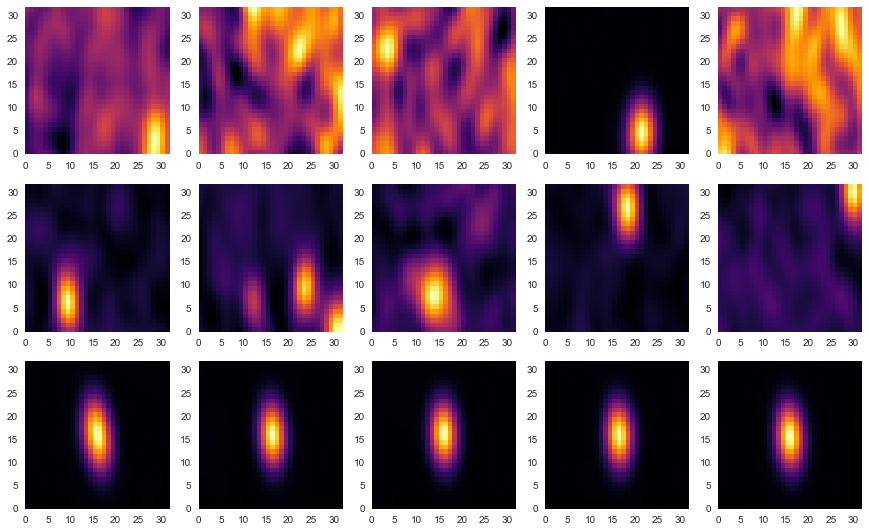

[[ 52.38486481 -28.31591606]
 [ 53.28443146 -27.39073181]
 [ 53.52865601 -27.24355698]
 [ 53.55995178 -28.59179306]
 [ 53.78241348 -27.58590126]]
[[ 51.96873474 -28.10467339]
 [ 52.70145416 -28.13674927]
 [ 53.13070679 -28.07299614]
 [ 53.64358902 -28.09086609]
 [ 53.8423233  -27.78775978]]
[[ 51.70287704 -28.79318047]
 [ 51.83250427 -28.04343033]
 [ 52.39089203 -28.69446564]
 [ 53.29249573 -27.81162643]
 [ 53.34930038 -27.40180779]]


In [80]:
# Get raw radio patches to look at.
with h5py.File('../data/crowdastro.h5') as f:
    plt.figure(figsize=(15, 9))
    for i, im in enumerate(f['/wise/cdfs/numeric'][sorted(most_negative), -1024:].reshape((5, 32, 32))):
        plt.subplot(3, 5, i + 1)
        plt.pcolor(im, cmap='inferno')
        plt.xlim((0, 32))
        plt.ylim((0, 32))
    for i, im in enumerate(f['/wise/cdfs/numeric'][sorted(least_negative), -1024:].reshape((5, 32, 32))):
        plt.subplot(3, 5, i + 6)
        plt.pcolor(im, cmap='inferno')
        plt.xlim((0, 32))
        plt.ylim((0, 32))
    for i, im in enumerate(f['/wise/cdfs/numeric'][sorted(most_positive), -1024:].reshape((5, 32, 32))):
        plt.subplot(3, 5, i + 11)
        plt.pcolor(im, cmap='inferno')
        plt.xlim((0, 32))
        plt.ylim((0, 32))
    plt.show()

    print(f['/wise/cdfs/numeric'][sorted(most_negative), :2])
    print(f['/wise/cdfs/numeric'][sorted(least_negative), :2])
    print(f['/wise/cdfs/numeric'][sorted(most_positive), :2])

In [ ]:
# Get the corresponding IR, too.

import requests